# Vorticity budget of the depth integrated flow

In [1]:
import xarray as xr, numpy as np, xgcm
import matplotlib.pyplot as plt
import sys, xesmf as xe
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker, string
import cartopy.feature as cfeature
sys.path.append('ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings("ignore")

/srv/conda/envs/notebook/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


In [2]:
import ecco_v4_py as ecco
import xarray as xr, numpy as np, xgcm

def depthIntVelocity_i(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(dg.drF * dg.hFacW)).sum(dim='k')

def depthIntVelocity_j(field):
    """Time mean and depth integrated version of the given field on tracer point."""
    return (field * np.array(dg.drF * dg.hFacS)).sum(dim='k')

def interp_2d_fld(ds, xfld, yfld):
    XGCM_grid = ecco.get_llc_grid(ds)
    velc = XGCM_grid.interp_2d_vector({'X': xfld, 'Y': yfld},boundary='fill')
    fld_E  = velc['X']*ds['CS'] - velc['Y']*ds['SN']
    fld_N  = velc['X']*ds['SN'] + velc['Y']*ds['CS']   
    return fld_E, fld_N

def vec_rot(ds,vect0,vect1):
    xfld = vect0.compute()
    yfld = vect1.compute()
    fld_E, fld_N = interp_2d_fld(ds, xfld, yfld)
    return fld_E, fld_N

def scalar_grads(ds,field):
    XGCM_grid = ecco.get_llc_grid(ds)
    ds_hatx_M = XGCM_grid.diff(field, 'X')
    ds_dx_hatx_M = ds_hatx_M / ds.dxC
    ds_haty_M = XGCM_grid.diff(field, 'Y')
    ds_dy_haty_M = ds_haty_M / ds.dyC
    return XGCM_grid.interp(ds_dx_hatx_M,'X'), XGCM_grid.interp(ds_dy_haty_M,'Y'),
    
def vec_grads(ds,vect0,vect1):
    XGCM_grid = ecco.get_llc_grid(ds)
    fld_E, fld_N = vec_rot(ds,vect0,vect1)
    du_dx = (XGCM_grid.diff(fld_E, 'X') / ds.dxC).compute()
    du_dy = (XGCM_grid.diff(fld_E, 'Y') / ds.dyC).compute()
    du_dx, du_dy = interp_2d_fld(ds, du_dx, du_dy)
    dv_dx = (XGCM_grid.diff(fld_N, 'X') / ds.dxC).compute()
    dv_dy = (XGCM_grid.diff(fld_N, 'Y') / ds.dyC).compute()
    dv_dx, dv_dy = interp_2d_fld(ds, dv_dx, dv_dy)
    return du_dx, du_dy, dv_dx, dv_dy

def curl_vec(ds,vect0,vect1):
    _, du_dy, dv_dx, _ = vec_grads(ds,vect0,vect1)
    return dv_dx-du_dy

def hor_div(ds, field):
    du_dx, _, _, dv_dy= vec_grads(ds,field)
    return du_dx+dv_dy 

def interp_f(ds):
    XGCM_grid = ecco.get_llc_grid(ds)
    OMEGA = 7.2921e-5
    RAD_EARTH = 6.378e6
    beta = 2*OMEGA*np.cos(ds.YC * np.pi /180.)/RAD_EARTH
    return XGCM_grid.interp(beta,'X'),XGCM_grid.interp(beta,'Y')

def comp_f(ds):
    XGCM_grid = ecco.get_llc_grid(ds)
    OMEGA = 7.2921e-5
    RAD_EARTH = 6.378e6
    return 2*OMEGA*np.sin(ds.YC * np.pi /180.)

# loading grid

In [3]:
time = pd.date_range(start='1992-01-01', end='2019-12-31', freq='ME')
path="../../ECCO/V4/r5/netcdf/native/geometry/"
dg = xr.open_mfdataset(path+'*.nc')

# loading data

In [5]:
path="../../ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_X/"
du = xr.open_mfdataset(path+'OCEAN_3D_MOMENTUM_TEND_X_mon_mean_*_ECCO_V4r5_native_llc0090.nc',
                      parallel=True,
                      )

path="../../ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_3D_MOMENTUM_TEND_Y/"
dv = xr.open_mfdataset(path+'OCEAN_3D_MOMENTUM_TEND_Y_mon_mean_*_ECCO_V4r5_native_llc0090.nc',
                      parallel=True,
                      )

### $\beta V= \frac{J(p_b,H)}{\rho_o}+ \hat z \cdot \left( \frac{\nabla \times \tau_s}{\rho_o} + \nabla \times \mathcal{A} +\nabla \times \mathcal{B}\right) -\hat z\cdot(\nabla \times V_t)\Large\Large$

### (Kathri et al., 2024)

### 1) Wind stress + bottom stress term: $\dfrac{\nabla \times \tau}{\rho_{0}}$
### where  $\tau$ is the sum of surface and bottom stress and $\rho_{0}$ is a refence density: 1029 kg/m${3}$

In [ ]:
zeta0 = curl_vec(dg,du.Um_Ext.sum(dim="k"), dv.Vm_Ext.sum(dim="k"))
zeta0.rename("term_d").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_d.nc")

### 2) Dissipation term: $\nabla \times \mathcal{B}$
### where $\mathcal{B}$ is the horizontal viscous friction

In [ ]:
dragU=(du.Um_Diss+du.Um_ImplD).sum(dim="k")
dragV=(dv.Vm_Diss+dv.Vm_ImplD).sum(dim="k")
zeta1= curl_vec(dg,dragU,dragV)
zeta1.rename("term_f").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_f.nc")

### 3) Coriolis term: $\beta V$
### where $\beta$ is the meridional derivative of the Coriolis parameter and V is the meridional componente of the flow

In [ ]:
dragU=(du.Um_Cori).sum(dim="k")
dragV=(dv.Vm_Cori).sum(dim="k")
zeta2 = curl_vec(dg,dragU,dragV)
zeta2.rename("term_a").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_a.nc")

### 4) Advection term: $\nabla \times \mathcal{A}$
### where $\mathcal{A}$ is the velocity advection

In [ ]:
dragU=(du.Um_Advec-du.Um_Cori).sum(dim="k")
dragV=(dv.Vm_Advec-dv.Vm_Cori).sum(dim="k")
zeta3 = curl_vec(dg,dragU,dragV)
zeta3.rename("term_c").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_c.nc")

### 5) Topography term: $\dfrac{J(p_{b},H)}{\rho_{0}}$
### where $p_{b}$ is the bottom pressure and H is the depth of the ocean bottom

In [ ]:
dragU=(du.Um_dPhiX).sum(dim="k")
dragV=(dv.Vm_dPhiY).sum(dim="k")
zeta4 = curl_vec(dg,dragU,dragV)
zeta4.rename("term_b").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_b.nc")

### 6) Local variation term: $\nabla \times V_t$
### where $V_t$ is the vertical integrated velocity tendency 

In [ ]:
uu = du.TOTUTEND/86400-du.Um_Advec-du.Um_Diss-du.Um_Ext-du.Um_dPhiX-du.AB_gU-du.Um_ImplD
vv = dv.TOTVTEND/86400-dv.Vm_Advec-dv.Vm_Diss-dv.Vm_Ext-dv.Vm_dPhiY-dv.AB_gV-dv.Vm_ImplD

dragU=(uu).sum(dim="k")
dragV=(vv).sum(dim="k")
zeta5 = curl_vec(dg,dragU,dragV)
zeta5.rename("term_t").to_netcdf("/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/term_t.nc")

### join tiles in a global map and saving in netcdf files

In [ ]:
path="/home/jovyan/efs_ecco/fgonzale/ecco_summer_school_2025/"

da = xr.open_mfdataset(path+'term_a.nc',
                      parallel=True,
                      )
db = xr.open_mfdataset(path+'term_b.nc',
                      parallel=True,
                      )
dc = xr.open_mfdataset(path+'term_c.nc',
                      parallel=True,
                      )
dd = xr.open_mfdataset(path+'term_d.nc',
                      parallel=True,
                      )
df = xr.open_mfdataset(path+'term_f.nc',
                      parallel=True,
                      )

dt = xr.open_mfdataset(path+'term_t.nc',
                      parallel=True,
                      )

In [ ]:
lon, lat, var_a, var_b, var_c, var_d, var_f, var_t = [], [], [], [], [], [], [], []
for i in range(da.time.size):
    print(i)
    in_data = dt.term_t.isel(time=i)
    curr_obj = ecco.plot_proj_to_latlon_grid(dg.XC,dg.YC,\
                                             in_data,\
                                             show_colorbar=True,\
                                             show_land=True,projection_type='robin',\
                                             user_lon_0=0,plot_type='pcolormesh',\
                                             cmin=-1e-10,cmax=1e-10,\
                                             cmap='coolwarm',
                                            )
    lon = curr_obj[4]
    lat = curr_obj[5]
    var_t.append(np.array(curr_obj[6]))
    plt.close()

da = xr.DataArray(
    np.array(var_t),
    dims=["time", "j","i"],
    coords={
        "longitude": (["j", "i"], lon),
        "latitude": (["j", "i"], lat)
    },
    name="term_time"
)
ds = da.to_dataset().to_netcdf("./term_time.nc")

### ploting time-mean depth integrated terms

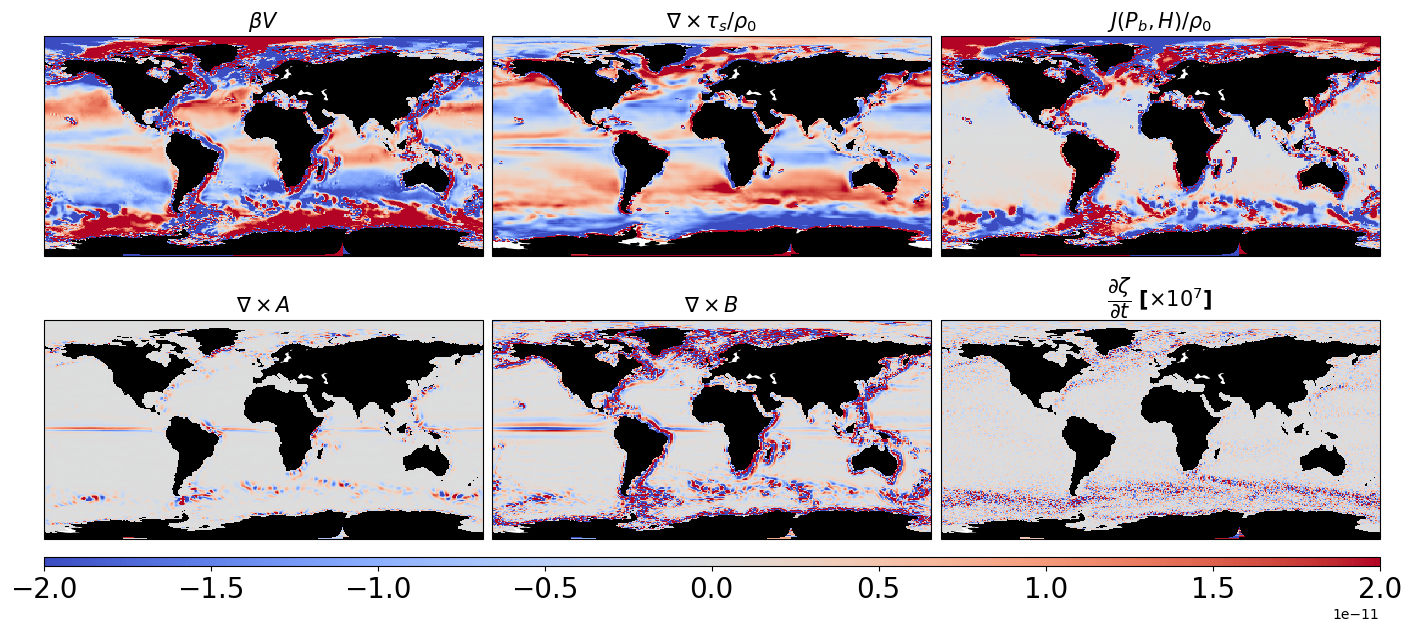

In [18]:
fig, ax = plt.subplots(nrows=2,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6.5),constrained_layout=True)

ds = xr.open_dataset("./term_Cori.nc")
var = ds.term_Cori.where(ds.term_Cori != 0, np.nan)

z00 = ax[0,0].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time"),
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[0,0].set_title(r"$ \beta V$",size=15, fontweight="bold")

ds = xr.open_dataset("./term_Sstr.nc")
var = ds.term_Sstr.where(ds.term_Sstr != 0, np.nan)
z01 = ax[0,1].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time"),
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[0,1].set_title(r"$ \nabla \times \tau_{s}/\rho_{0}$",size=15, fontweight="bold")

ds = xr.open_dataset("./term_Topo.nc")
var = ds.term_Topo.where(ds.term_Topo != 0, np.nan)
z02 = ax[0,2].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time"),
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[0,2].set_title(r"$ J(P_{b},H)/\rho_{0}$",size=15, fontweight="bold")

ds = xr.open_dataset("./term_Adv.nc")
var = ds.term_Adv.where(ds.term_Adv != 0, np.nan)
z10 = ax[1,0].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time"),
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[1,0].set_title(r"$ \nabla \times A$",size=15, fontweight="bold")

ds = xr.open_dataset("./term_Diss.nc")
var = ds.term_Diss.where(ds.term_Diss != 0, np.nan)
z11 = ax[1,1].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time"),
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[1,1].set_title(r"$ \nabla \times B$",size=15, fontweight="bold")

ds = xr.open_dataset("./term_time.nc")
var = ds.term_time.where(ds.term_time != 0, np.nan)
z11 = ax[1,2].pcolormesh(ds.longitude, ds.latitude, var.mean(dim="time")*1e7,
                      vmin=-2e-11,vmax=2e-11,
                      cmap='coolwarm',transform = ccrs.PlateCarree(),rasterized=True,)
ax[1,2].set_title(r"$ \dfrac{\partial \zeta }{\partial t}$ [$\times 10^{7}$]",size=15, fontweight="bold")

cb = plt.colorbar(z11, ax=ax, orientation='horizontal', pad =0.03, aspect=140, fraction=0.03)
cb.ax.tick_params(labelsize=20)

for i in range(2):
    for j in range(3):
        gl = ax[i,j].gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                               linewidth=1, color='black', alpha=.0,)
        ax[i,j].add_feature(cfeature.LAND, color='black')

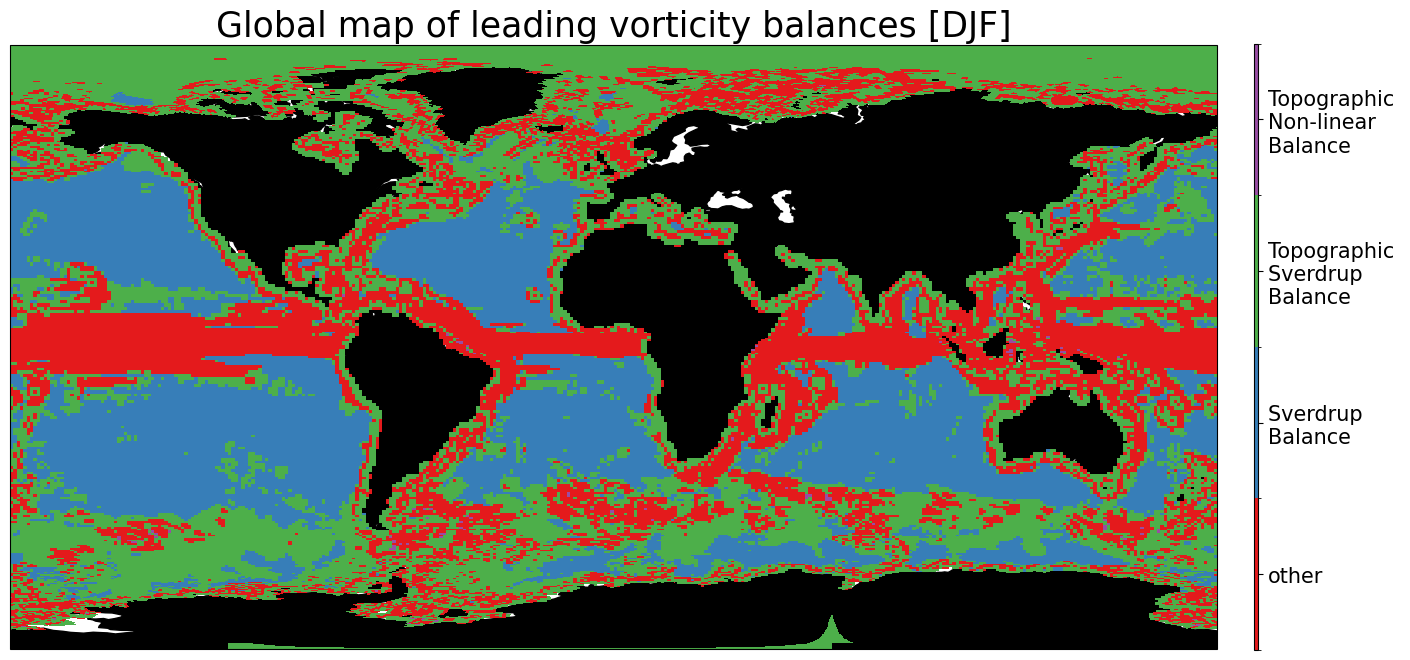

In [41]:
from matplotlib.colors import ListedColormap, BoundaryNorm

fig, ax = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(14,6.5),constrained_layout=True)

colors = ['lightgray', 'blue', 'orange', 'red']  
cmap = ListedColormap(colors)

bounds = [0, 1, 2, 3, 4]
norm = BoundaryNorm(bounds, cmap.N)

cmap="Set1"
z00 = ax.pcolormesh(ds.longitude, ds.latitude, mask,
                    norm=norm,
                         cmap=cmap,transform = ccrs.PlateCarree(),rasterized=True,)

ax.set_title("Global map of leading vorticity balances [DJF]", size=25)

cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), 
                  ax=ax, 
                  orientation='vertical', 
                  pad =0.03, aspect=140, fraction=0.03,
                 ticks=[0.5, 1.5, 2.5, 3.5]
                 )

cb.ax.tick_params(labelsize=15)
cb.ax.set_yticklabels(['other', 'Sverdrup \nBalance', 'Topographic \nSverdrup \nBalance', 'Topographic \nNon-linear \nBalance'])

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                               linewidth=1, color='black', alpha=.0,)
ax.add_feature(cfeature.LAND, color='black')